# Exploratory Data Analysis on Seattle Airbnb Open Data

In this notebook, CRISP-DM process is followed to answer few business questions about Airbnb Seattle using the Open Data on [Kaggle](https://www.kaggle.com/airbnb/seattle) from Jan '16 to Jan'17.

## Business Understanding
- What is the average daily booking price for a couple stay in Seattle Airbnb?
- How much do Seattle Airbnb homes are earning in certain time frames of the year?
- Which are the busiest/expensive neighbourhoods in Seattle?
- What are the most common type of Airbnb properties in Seattle?
- Is there anything about the properties that can help us to predict the price?

# Data Understanding

#### Importing required libraries/modules

In [3]:
import pandas as pd #ver = '0.23.0'
import numpy as np #ver = 1.14.3
import matplotlib #ver = 2.2.2
import seaborn as sns #ver = 0.8.1
import matplotlib.pyplot as plt
from scipy import stats

#sklearn ver = 0.19.1
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score,r2_score, mean_squared_error

%matplotlib inline

# Handle date time conversions between pandas and matplotlib
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Use white grid plot background from seaborn
sns.set(font_scale=1.5, style="whitegrid")
sns.set_context('talk') 
import matplotlib.style as style
style.use('ggplot')


### Reading Airbnb Seattle data

In [4]:
s_listing_df = pd.read_csv('listings.csv')
print("Seattle listing data, full desc and avg review score",s_listing_df.shape)

s_calendar = pd.read_csv('calendar.csv', parse_dates= ['date'])
print("Seattle Calendar, including listing id and the price and availability for that day",s_calendar.shape)

#As we are not doing text analytics in this notebook, review data is not loaded
#s_review = pd.read_csv('reviews.csv')
#print("Seattle Reviews, including unique id for each reviewer and detailed comments",s_review.shape)


Seattle listing data, full desc and avg review score (3818, 92)
Seattle Calendar, including listing id and the price and availability for that day (1393570, 4)


#### A look at listing data

In [5]:
s_listing_df.head(2)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48


In [6]:
s_listing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
id                                  3818 non-null int64
listing_url                         3818 non-null object
scrape_id                           3818 non-null int64
last_scraped                        3818 non-null object
name                                3818 non-null object
summary                             3641 non-null object
space                               3249 non-null object
description                         3818 non-null object
experiences_offered                 3818 non-null object
neighborhood_overview               2786 non-null object
notes                               2212 non-null object
transit                             2884 non-null object
thumbnail_url                       3498 non-null object
medium_url                          3498 non-null object
picture_url                         3818 non-null object
xl_picture_url                      3498

- There are 61 string and 31 numeric columns. 
- From the info we see that the data type of price columns is object, we have to convert it to numeric for doing the EDA.

In [7]:
# missing values
missing_data = s_listing_df.isna().mean().sort_values(ascending =False)*100            
print(len(missing_data[missing_data > 0]))
missing_data[missing_data > 0]

45


license                        100.000000
square_feet                     97.459403
monthly_price                   60.267156
security_deposit                51.126244
weekly_price                    47.380828
notes                           42.063908
neighborhood_overview           27.029859
cleaning_fee                    26.977475
transit                         24.463070
host_about                      22.498690
host_acceptance_rate            20.246202
review_scores_accuracy          17.234154
review_scores_checkin           17.234154
review_scores_value             17.181771
review_scores_location          17.155579
review_scores_cleanliness       17.103195
review_scores_communication     17.050812
review_scores_rating            16.946045
reviews_per_month               16.422211
first_review                    16.422211
last_review                     16.422211
space                           14.903091
host_response_time              13.698271
host_response_rate              13

**listings** dataset contains missing values in 45 columns out of 92.

#### A look at calendar dataset

In [8]:
s_calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [9]:
s_calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
listing_id    1393570 non-null int64
date          1393570 non-null datetime64[ns]
available     1393570 non-null object
price         934542 non-null object
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 42.5+ MB


In [10]:
#number of bookings for each of the 3818 listings
s_calendar['listing_id'].value_counts().unique()

array([365], dtype=int64)

In [11]:
s_calendar['price'].describe().transpose() #most common price is 150$

count      934542
unique        669
top       $150.00
freq        36646
Name: price, dtype: object

In [12]:
#missing values
s_calendar.isna().sum()

listing_id         0
date               0
available          0
price         459028
dtype: int64

## Data Preparation

In [13]:
def format_removed_columns_msg(count, col_types, rows, cols):
    '''Format print message
    
    params:
    count - number of columns in the list
    col_types - type of data removed, e.g - id, url, etc.
    rows - number of rows in the updated listing dataframe
    cols - number of columns in the updated listing dataframe
    '''   
    print("Removed {count} {col_types} columns from listings data, Updated data has {rows} rows and {cols} columns".format(count =count, col_types =col_types, rows = rows, cols = cols))
    

In [14]:
def remove_dollar_from_price(df,var):
    '''
    Remove special characters from numerical data, e.g $ 
    
    Input - 
        df - dataframe
        var - column_name
        
    Output - extracted value
    '''
    if df.dtypes[var] == 'O':
        df[var] = df[var].str.extract('([0-9.]+)').astype('float64')
        print("Removed $ from the column", var)
    else:
        print("The {var} column is already cleaned.".format(var = var))

In [15]:
remove_dollar_from_price(s_calendar,'price') #remove $ from price in calendar dataset
remove_dollar_from_price(s_listing_df,'price') #remove $ from price in listings dataset

Removed $ from the column price
Removed $ from the column price


### Exploratory Data Analysis - Discover and visualize the data to gain insights

#### price(target variable) - booking price

In [16]:
s_listing_df['price'].describe()

count    3818.00000
mean      127.71451
std        89.16278
min         1.00000
25%        75.00000
50%       100.00000
75%       150.00000
max       999.00000
Name: price, dtype: float64

Average booking price is 127

C:\Users\Abhinay\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


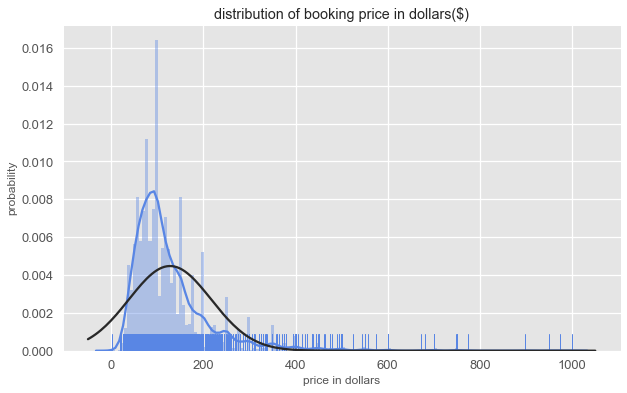

In [17]:
#plot distribution of price in listings dataset
fig, ax = plt.subplots(figsize=(10, 6))
sns.distplot(s_listing_df['price'], kde=True, rug=True, ax=ax, bins=150, fit=stats.norm, color= '#5986e4')
ax.set(title= 'distribution of booking price in dollars($)', xlabel='price in dollars', ylabel='probability')
plt.show()

---
- Distribution of `price` is highly righ skewed, so we should use transformation like log, box-cox etc for prediction.
- Most of the booking price lies between 50 dollars and 200 dollars.
- There are outliers in this dataset. You can see from thoes virticle lines (same height dark blue sticks) in the plot are dense below 500.
---

C:\Users\Abhinay\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


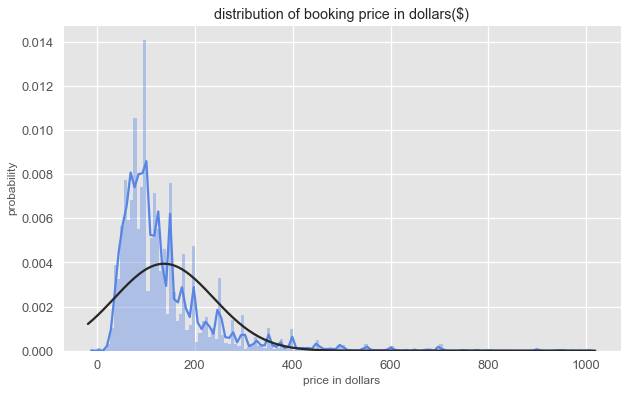

In [18]:
#plot distribution of price in calendar dataset
s_calendar_price_copy = s_calendar.dropna(subset = ['price'])
fig, ax = plt.subplots(figsize=(10, 6))
sns.distplot(s_calendar_price_copy['price'],  ax=ax, bins=150, fit=stats.norm, color= '#5986e4')
ax.set(title= 'distribution of booking price in dollars($)', xlabel='price in dollars', ylabel='probability')
plt.show()

### 1. How much would it cost for a couple per day to stay in Seattle Airbnb homes?

In [19]:
#Avergae price per day by guests_included
listing_guest_included = s_listing_df.groupby('accommodates')['price'].mean().reset_index()
listing_guest_included.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
accommodates,1.000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,10.00,11.000000,12.000000,14.000000,15.0,16.00
price,58.375,91.296865,111.600503,139.001274,181.804348,198.572289,220.788462,295.478992,396.153846,362.64,566.666667,345.666667,381.333333,286.0,439.75


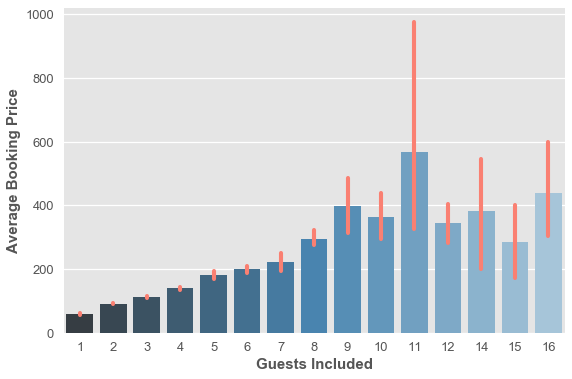

In [20]:
#plot accomodates against price to find the avergage booking price based on the number of guests
plt.figure(figsize= (9,6))
sns.barplot(x = 'accommodates', y = 'price', data= s_listing_df, palette= 'Blues_d', errcolor= 'salmon')

plt.xlabel('Guests Included', fontsize = 15, weight = 'bold')
plt.ylabel('Average Booking Price', fontsize = 15, weight = 'bold')
plt.savefig('accommodates.png')


- One night-stay in Airbnb Seattle would cost close to 91 dollars for a single person and 112 dollars for a couple.
- There are lot of outliers in the data. The little orange line indicates the present of outliers.

### 2. How much Airbnb homes are earning in certain time frames and areas.?

The best way to find a trend in the data is to plot time series. I have used **Booking Date** from the calendar dataset and used [**pandas.Grouper**](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Grouper.html) inside groupby() to find the average booking price monthly.

#### Is there a trend in the booking price during any time of the year?

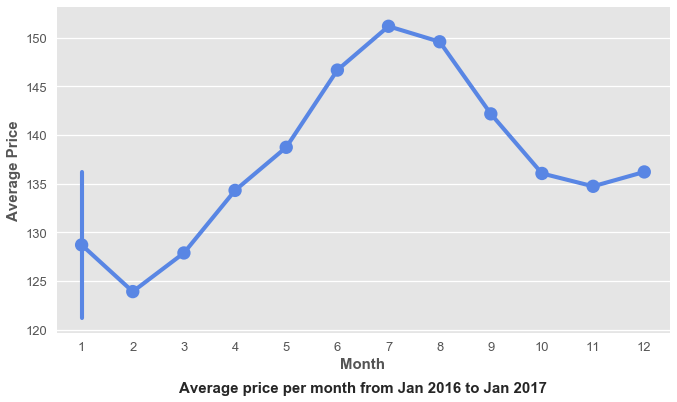

In [21]:
plt.figure(figsize=(11,6))
s_calendar_monthly = s_calendar.groupby(pd.Grouper(key = 'date',freq ='1M')).mean()

sns.pointplot(x = s_calendar_monthly.index.month, y = s_calendar_monthly.price,color= '#5986e4')#5986e4 #5c81e2 #4b97ec

plt.title('Average price per month from Jan 2016 to Jan 2017', y=-0.20,fontsize = 15, weight = 'bold')
plt.xlabel('Month', fontsize = 15, weight = 'bold')
plt.ylabel('Average Price', fontsize = 15, weight = 'bold')
plt.savefig('price_per_month.png')

--- 
- There is an upward trend in price from Feb'16 to July'16 where the average price rises to the highest which is $153 per day.
- There is a downward trend till Nov'16. 
- The best time to visit Seattle is in Summers from June to August.
- A little vertical line in Jan means that there are 2 average price for 2016 and 2017: The mean price in Jan'17 is higher than Jan'16.
---

#### Is there a spike in booking price during the weekends?

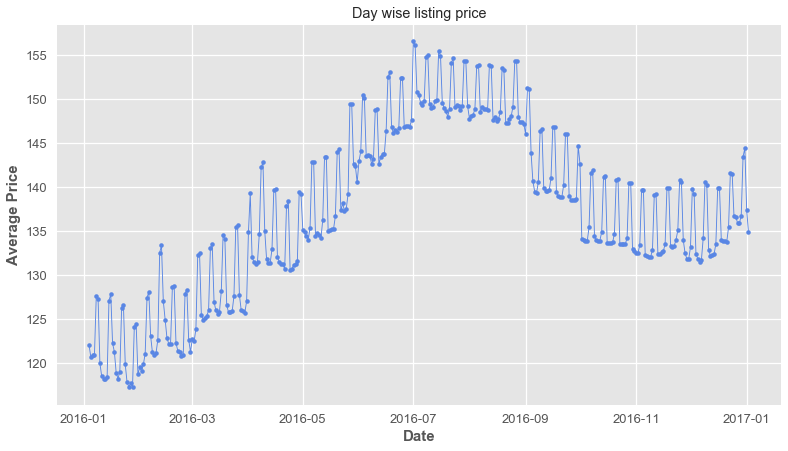

In [22]:
'''Use calendar data to plot each date against the mean price '''
s_calendar_copy = s_calendar.copy(deep= True)
s_calendar_copy.dropna(inplace=True)
s_calendar_copy['date'] = pd.to_datetime(s_calendar_copy['date'])

#plot avg listings prices over time.
s_calendar_copy = s_calendar_copy.groupby('date')['price'].mean().reset_index()

plt.figure(figsize=(13, 7))
plt.plot(s_calendar_copy.date, s_calendar_copy.price, marker='.', linewidth=0.9,color= '#5986e4')
plt.title("Day wise listing price")

plt.xlabel('Date', fontsize = 15, weight = 'bold')
plt.ylabel('Average Price', fontsize = 15, weight = 'bold')
plt.savefig('price_per_day.png')

- There is a periodic small peak in the graph which could be an indicator of seasonality in the weekends.

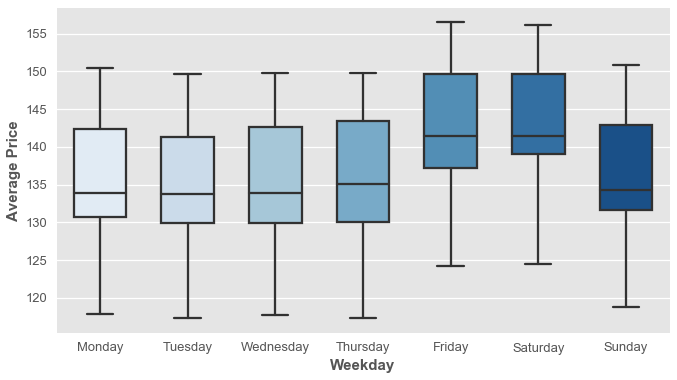

In [23]:
# create weekday column
s_calendar_copy["weekday"] = s_calendar_copy["date"].dt.weekday_name

# boxplot to see price distribution by weekdays
plt.figure(figsize=(11, 6))
sns.boxplot(x = 'weekday',  y = 'price', data = s_calendar_copy, palette="Blues", width=0.6)

plt.xlabel('Weekday', fontsize = 15, weight = 'bold')
plt.ylabel('Average Price', fontsize = 15, weight = 'bold')

plt.savefig('price_per_day_week.png')

- There is a peak in the booking price on Friday and Saturday and then lowering on Sunday.
- There is the weekly trend where the listing prices in weekends are higher than other weekday.

In [24]:
s_listing_df['price'].describe()

count    3818.00000
mean      127.71451
std        89.16278
min         1.00000
25%        75.00000
50%       100.00000
75%       150.00000
max       999.00000
Name: price, dtype: float64

### 3. Which are the busiest/most expensive neighbourhoods in Seattle?

In [25]:
#find all the neighbourhood related columns to choose the best one for exploring
s_listing_df[[i for i in s_listing_df if 'neigh' in i]].head()

,neighborhood_overview,host_neighbourhood,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed
0,NaN,Queen Anne,Queen Anne,West Queen Anne,Queen Anne
1,"Queen Anne is a wonderful, truly functional vi...",Queen Anne,Queen Anne,West Queen Anne,Queen Anne
2,Upper Queen Anne is a charming neighborhood fu...,Queen Anne,Queen Anne,West Queen Anne,Queen Anne
3,NaN,Queen Anne,Queen Anne,West Queen Anne,Queen Anne
4,We are in the beautiful neighborhood of Queen ...,Queen Anne,Queen Anne,West Queen Anne,Queen Anne


---
- neighbourhood_cleansed seems to be the best column for neighbourhood as it contains the cleaned info,I will be using this for all the visualizations.
- neighbourhood_group_cleansed is the district of the nwighbourhoods.
---

#### 10 busiest neighbourhood in Seattle for Airbnb homestays

In [26]:
#use groupby to get the top 10 neighbourhood grouped by neighbourhood_group_cleansed and neighbourhood_cleansed count

s_listing_df_neigh_group_price = s_listing_df.groupby(['neighbourhood_group_cleansed','neighbourhood_cleansed'])['price'].count().sort_values(ascending = False)[:10]
s_listing_df_neigh_group_price

neighbourhood_group_cleansed  neighbourhood_cleansed   
Capitol Hill                  Broadway                     397
Downtown                      Belltown                     234
Other neighborhoods           Wallingford                  167
                              Fremont                      158
Central Area                  Minor                        135
University District           University District          122
Capitol Hill                  Stevens                      119
Downtown                      First Hill                   108
                              Central Business District    103
Queen Anne                    Lower Queen Anne              94
Name: price, dtype: int64

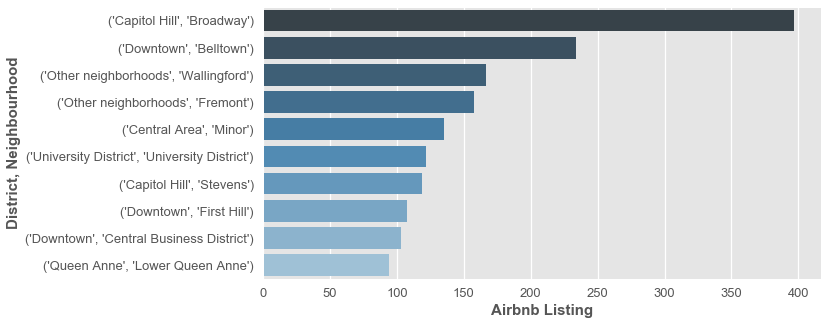

In [27]:
#plot the groupby output
plt.figure(figsize=(10,5))
sns.barplot(y = s_listing_df_neigh_group_price.index, x = s_listing_df_neigh_group_price.values,palette= 'Blues_d')
plt.ylabel('District, Neighbourhood', fontsize = 15, weight = 'bold')
plt.xlabel('Airbnb Listing', fontsize = 15, weight = 'bold')
plt.savefig('busiest_neigh.png')

- Broadway, Capitol Hill is the most crowded neighbourhood in Seattle with 394 Airbnb properties.
- Belltown, Downtown is the 2nd busiest neighbourhood with 234 properties.
- There are a total of 94-394 properties in the 10 busiest neighbourhoods.

#### Which are the most quiet neighbourhood in Seattle for Airbnb stay?

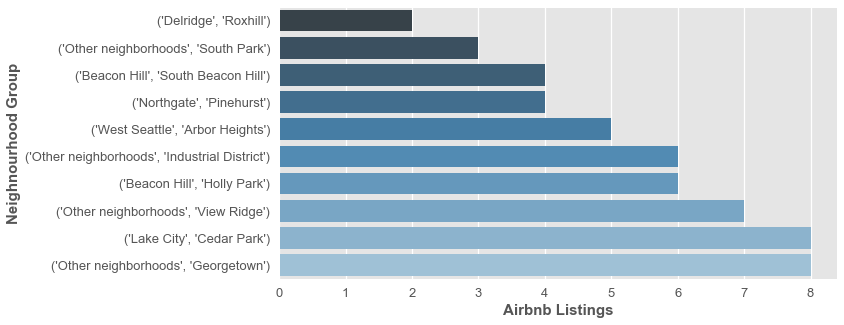

In [28]:
#plot the neighbourhoods group by lowest count of neighbourhood
plt.figure(figsize=(10,5))
s_listing_df_neigh_group_price_quiet = s_listing_df.groupby(['neighbourhood_group_cleansed','neighbourhood_cleansed'])['price'].count().sort_values(ascending = True)[:10]
sns.barplot(y = s_listing_df_neigh_group_price_quiet.index, x = s_listing_df_neigh_group_price_quiet.values,palette= 'Blues_d')
plt.ylabel('Neighnourhood Group', fontsize = 15, weight = 'bold')
plt.xlabel('Airbnb Listings', fontsize = 15, weight = 'bold')
plt.savefig('quiet_neigh.png')

- Roxhill, Delridge is the least busy neighbourhood with just 2 Airbnb properties
- South Park has 3 properties

#### 10 most expensive neighbourhood in Seattle

Text(0.5,0,'Avergae Price')

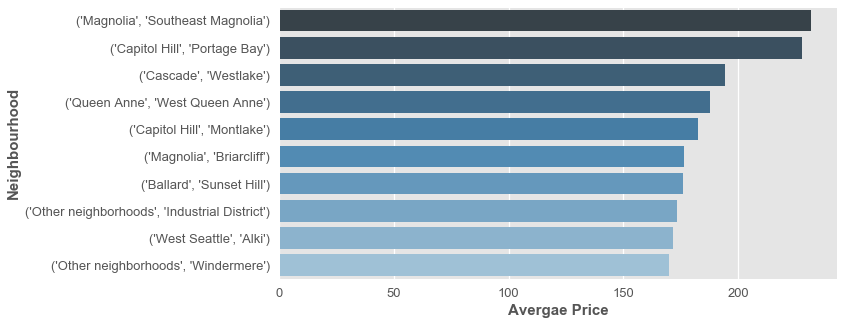

In [29]:
#plot the 10 most expensive neighbourhood group by highest mean price
plt.figure(figsize=(10,5))
s_listing_df_price_by_area = s_listing_df.groupby(['neighbourhood_group_cleansed','neighbourhood_cleansed'])['price'].mean().sort_values(ascending = False)[:10]
sns.barplot(y = s_listing_df_price_by_area.index, x = s_listing_df_price_by_area.values,palette= 'Blues_d')
plt.ylabel('Neighbourhood', fontsize = 15, weight = 'bold')
plt.xlabel('Avergae Price', fontsize = 15, weight = 'bold')

- Southeast Magnolia is the most expensive place to stay in Seattle with an average price per night around 232 dollars.
- The 2nd most expensive neighbourhood, Portage Bay in Capitol Hill has an average price close to 227 dollars. 
- Staying in the 10 most expensive neighbourhood would cost 170 - 232 dollars a night.

#### 10 cheapest neighbourhood in Seattle

Text(0.5,0,'Avergae Price')

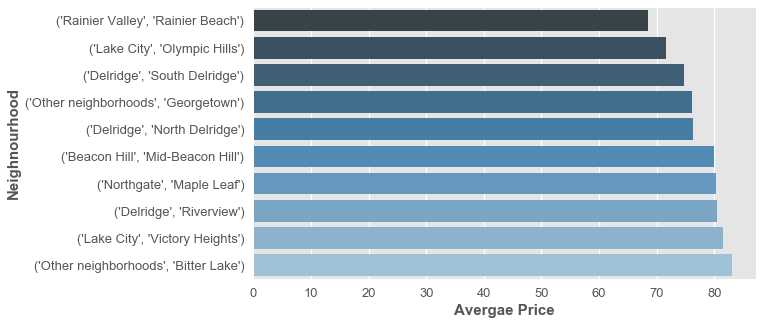

In [30]:
#plot 10 cheapest neighbourhood group by mean price
fig, ax = plt.subplots(figsize=(9,5))
s_listing_pivot = s_listing_df.groupby(['neighbourhood_group_cleansed','neighbourhood_cleansed'])['price'].mean().sort_values(ascending = True)[:10]
sns.barplot(x =s_listing_pivot.values , y= s_listing_pivot.index, palette= 'Blues_d')
plt.ylabel('Neighnourhood', fontsize = 15, weight = 'bold')
plt.xlabel('Avergae Price', fontsize = 15, weight = 'bold')

- Rainier Beach is the cheapest neighbourhood in Seattle with a mean price of below 70 dollars.
- Top 10 cheapest neighbourhood in Seattle have a mean price per day in the range of 68 to 82 dollars.  

In [31]:
#s_listing_df['price'].sort_values(ascending=False).unique()

### 4. What are the most common type of Airbnb properties in Seattle?

In [32]:
s_listing_df['property_type'].value_counts()

House              1733
Apartment          1708
Townhouse           118
Condominium          91
Loft                 40
Bed & Breakfast      37
Other                22
Cabin                21
Bungalow             13
Camper/RV            13
Boat                  8
Tent                  5
Treehouse             3
Chalet                2
Dorm                  2
Yurt                  1
Name: property_type, dtype: int64

Text(0.5,0,'Property Type')

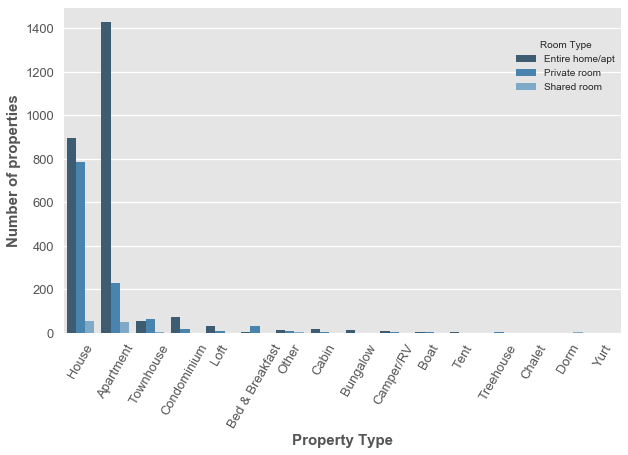

In [33]:
# plot a countplot of peoperties with hue as room_type
plt.figure(figsize=(10,6))
sns.countplot(x = 'property_type', data = s_listing_df,hue = 'room_type', palette= 'Blues_d',
             order=s_listing_df.property_type.value_counts().index)
plt.xticks(rotation=60)
plt.legend(bbox_to_anchor = (1.05,1), loc =1, borderaxespad =3., title = 'Room Type', fontsize = 'medium')
plt.ylabel('Number of properties', fontsize = 15, weight = 'bold')
plt.xlabel('Property Type', fontsize = 15, weight = 'bold')

---
- Houses and Apartments occupy 90% of all the Airbnb properties in Seattle with 1733 Houses followed by 1708 Apartments. 
- Yurt, Dorm and Chalet are available to Nil in Seattle.
- And as you can see from the above plot, most of the properties have preferred room type as House/Apt and Private in contrast to shared rooms.
---

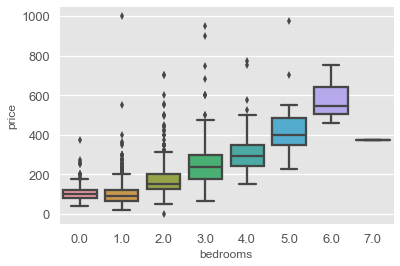

In [34]:
#plot bedrooms agains the price
sns.boxplot(x='bedrooms',y='price',data=s_listing_df)

### 5. Is there anything about the properties that can help us to predict the price?

#### Data cleaning for model building

In [35]:
'''Clean Data
    1. remove columns containing single value as they hold no significant information
    2. remove columns contining urls
    3. remove columns containing ids 
    4. remove textual columns as we are not doing text mining in this notebook '''
#check fr the single value for a categorical column
#df_listing_cat =s_listing_df.select_dtypes(include=['object']).copy()
single_category = []
drop_url_col = []
drop_id_col= []
drop_text_column = []
for i in s_listing_df.columns:
    if len(s_listing_df[i].unique())==1:
        single_category.append(i)
    elif 'url' in i:
        drop_url_col.append(i)
    elif '_id' in i:
        drop_id_col.append(i)
    elif s_listing_df[i].dtype == np.dtype('O') and len(s_listing_df[i].unique())>20 and s_listing_df[i].str.contains('.{40,}[^0-9a-zA-Z,]+[A-Za-z]+', regex = True).any():
            drop_text_column.append(i)
# remove columns containing single value as they hold no significant information 
s_listing_df.drop(single_category, axis=1, inplace= True)
format_removed_columns_msg(len(single_category), "single value", s_listing_df.shape[0], s_listing_df.shape[1])

#remove columns contining urls
s_listing_df.drop(drop_url_col, axis=1, inplace= True)
format_removed_columns_msg(len(drop_url_col), "url", s_listing_df.shape[0], s_listing_df.shape[1])

#remove columns containing ids 
s_listing_df.drop(drop_id_col, axis=1, inplace= True)
format_removed_columns_msg(len(drop_id_col), "id", s_listing_df.shape[0], s_listing_df.shape[1])

#remove textual columns
s_listing_df.drop(drop_text_column, axis=1, inplace= True)
format_removed_columns_msg(len(drop_text_column), "textual", s_listing_df.shape[0], s_listing_df.shape[1])
#print(s_listing_df.shape)

Removed 11 single value columns from listings data, Updated data has 3818 rows and 81 columns
Removed 8 url columns from listings data, Updated data has 3818 rows and 73 columns
Removed 2 id columns from listings data, Updated data has 3818 rows and 71 columns
Removed 11 textual columns from listings data, Updated data has 3818 rows and 60 columns


In [36]:
#Remove columns holding duplicate information and irrelevant columns
irrelevant_cols = ['first_review', 'last_review','name','host_name' ,'city','state','zipcode','smart_location',
                   'calendar_updated','reviews_per_month','require_guest_phone_verification','require_guest_profile_picture',
                   'host_acceptance_rate','host_has_profile_pic','host_total_listings_count','calculated_host_listings_count',
                   'neighbourhood_cleansed','host_neighbourhood',
                   'neighbourhood','host_response_time']

s_listing_df.drop(irrelevant_cols, axis=1, inplace= True)

format_removed_columns_msg(len(irrelevant_cols), "irrelevant/duplicate", s_listing_df.shape[0], s_listing_df.shape[1])

Removed 20 irrelevant/duplicate columns from listings data, Updated data has 3818 rows and 40 columns


In [37]:
#drop the columns containing more than 40% missing values
drop_missing_values_col = list(set(s_listing_df.columns[s_listing_df.isna().mean() >.40]))
s_listing_df.drop(drop_missing_values_col, axis=1, inplace= True)

print(s_listing_df.shape)

format_removed_columns_msg(len(drop_missing_values_col), "", s_listing_df.shape[0], s_listing_df.shape[1])

(3818, 36)
Removed 4  columns from listings data, Updated data has 3818 rows and 36 columns


In [38]:
#merge listings data with calendar data
s_listing_df = s_listing_df.rename(index=str, columns={"id": "listing_id"})
s_listing_df =s_listing_df.drop('price', axis =1)
df = pd.merge(s_calendar, s_listing_df, on = 'listing_id')
print(df.shape)

#convert date from the calendar into month and drop the date colum

df['month'] = pd.to_datetime(df['date']).dt.month
df['year'] = pd.to_datetime(df['date']).dt.year
df = df.drop(columns = ['date'])

#remove rows where price == nan, because price will be used as target column
df = df.dropna(subset=['price'])

#remove_dollar_from_price(df,'price')
df = df.drop(columns = ['available'])
print(df.shape)
#Satte has a two same values - case sensitive, we can remove this col as well

(1393570, 38)
(934542, 38)


In [39]:
# convert true or false value to 1 or 0
df['host_is_superhost'].fillna('f', inplace = True)
dummy_cols = ['instant_bookable', 
              'is_location_exact',
              'host_is_superhost']

for col in dummy_cols:
    df[col] = df[col].map(lambda x: 1 if x == 't' else 0)

#remove null values from property type as there are only 0.03 % null values
df['property_type'].dropna(inplace = True)
df =df.reset_index()

In [40]:
def get_host_since_year(row):
    ''' Get year from a date represented as a string '''
    try:
        host_since = pd.to_numeric(row['host_since'].split('-')[0])
    except:
        host_since = np.nan
    return host_since

#convert host_since date into number and fill in missing values, drop the original column
df['host_since_year'] = df.apply(lambda x: get_host_since_year(x),axis=1)
df['host_since_year'].fillna(df['host_since_year'].mean(), inplace = True)
df = df.drop(columns = ['host_since'])

#convert host_response_rate into number and fill in missing values
df['host_response_rate'] = df['host_response_rate'].astype(str)
df['host_response_rate'] = df['host_response_rate'].str.replace("%", "").astype("float")
df['host_response_rate'].fillna(df['host_response_rate'].mean(), inplace = True)

#fill missing values with mean value for host_listings_count
df['host_listings_count'].fillna(df['host_listings_count'].mean(), inplace = True)

#fill in missing values for bathrooms, bedrooms and beds with mode
mode_col = ['bathrooms','bedrooms','beds']
for col in mode_col:
    df[col] = df[col].fillna(df[col].mode()[0])

#Remove $,% from numerical columns and fill null values
remove_dollar_from_price(df,'cleaning_fee')
remove_dollar_from_price(df,'extra_people')

#fill in missing values of rest of the numerical columnd with mean()
df_numeric =df.select_dtypes(include=['int64','float'])
for col in df_numeric.columns:
    df[col].fillna(df[col].mean(),inplace = True)

#split categorical columns to dummy columns and remove the original ones
categorical_cols =df.select_dtypes(include=['object'])
for col in categorical_cols.columns:
    dummies = pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True)
    df = pd.concat([df.drop(col, axis=1), dummies], axis=1)
print(df.shape)

Removed $ from the column cleaning_fee
Removed $ from the column extra_people
(934542, 73)


#### Plot a heat map of the pairwise correlation of numeric features including the target(price).
The easiest way to find out if there is any relationship between features and target for doing feature selection is to get the correlation measure for every feature in the dataset.


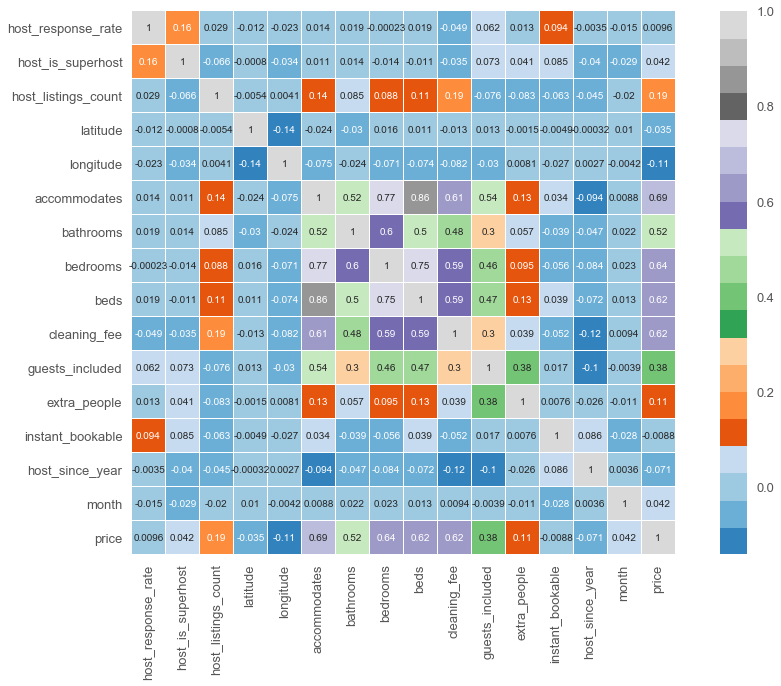

In [41]:
plt.figure(figsize=(16,10))
df_num = [ 'host_response_rate','host_is_superhost',
       'host_listings_count', 'latitude', 'longitude',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'cleaning_fee',
       'guests_included', 'extra_people', 'instant_bookable',
       'host_since_year','month', 'price']

sns.heatmap(df[df_num].corr(), cbar= True, annot= True,square= True,linewidths=0.3, cmap= 'tab20c')
plt.savefig('heatmap.png')

The numerical features - accommodates, bedrooms, beds, cleaning fee are highly positively correlated to the price whereas host_since_year is negatively correlated.

In [42]:
df[df_num].corr()['price'].sort_values()

longitude             -0.111908
host_since_year       -0.071049
latitude              -0.034871
instant_bookable      -0.008794
host_response_rate     0.009569
month                  0.041545
host_is_superhost      0.042268
extra_people           0.107092
host_listings_count    0.187818
guests_included        0.383615
bathrooms              0.524275
beds                   0.617077
cleaning_fee           0.623144
bedrooms               0.636860
accommodates           0.685759
price                  1.000000
Name: price, dtype: float64

Text(0.5,-92.35,'Numerical Features')

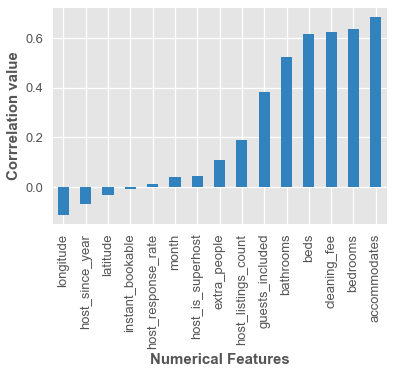

In [43]:
#plot the correlation values of the target(price) variable:
df[df_num].corr()['price'][:-1].sort_values().plot(kind='bar', colormap = 'tab20c')
plt.savefig('heatmap_plot.png')
plt.ylabel('Corrrelation value', fontsize = 15, weight = 'bold')
plt.xlabel('Numerical Features', fontsize = 15, weight = 'bold')

#### Model Building

In [44]:
#Prepare the train and test data, using 70:30 ratio for train and test
X= df.drop(columns= ['price','listing_id','index'])
y = df['price']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(654179, 70)
(280363, 70)
(654179,)
(280363,)


In [45]:
tree_reg  = RandomForestRegressor( random_state= 42)
tree_reg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

#### Model evaluation

In [46]:
#calculate scores for the model
y_train_preds = tree_reg.predict(X_train)
y_test_preds = tree_reg.predict(X_test)

print('Random Forest RMSE train: %.3f, test: %.3f' % (
        np.sqrt(mean_squared_error(y_train, y_train_preds)),
        np.sqrt(mean_squared_error(y_test, y_test_preds))))
print('Random Forest R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_preds),
        r2_score(y_test, y_test_preds)))

Random Forest RMSE train: 13.743, test: 14.532
Random Forest R^2 train: 0.982, test: 0.979


R^2 score is quite good for both train and test data.

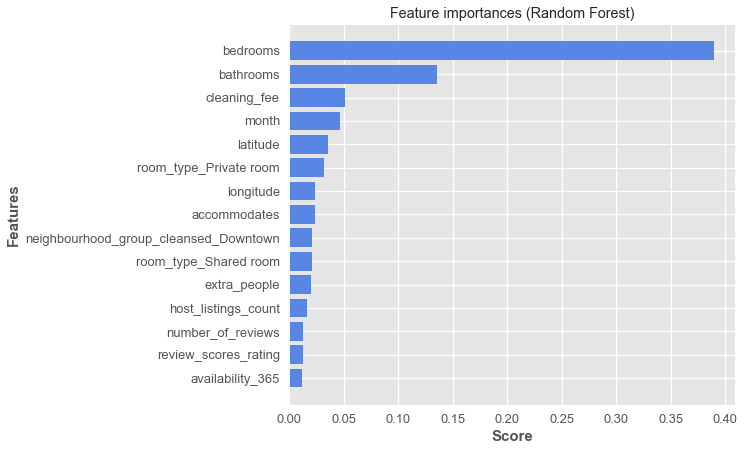

In [47]:
#plot feature importances from the model
headers = ["name", "score"]
values = sorted(zip(X_train.columns, tree_reg.feature_importances_), key=lambda x: x[1] * -1)
forest_feature_importances = pd.DataFrame(values, columns = headers)
forest_feature_importances = forest_feature_importances.sort_values(by = ['score'], ascending = False)

features = forest_feature_importances['name'][:15]
y_pos = np.arange(len(features))
y_pos = np.sort(y_pos)[::-1]
scores = forest_feature_importances['score'][:15]
#plot feature importances
plt.figure(figsize=(8 ,7))
plt.barh(y_pos, scores, align='center', color = '#5986e4')
plt.yticks(y_pos, features)
plt.ylabel('Features', fontsize = 15, weight = 'bold')
plt.xlabel('Score', fontsize = 15, weight = 'bold')
plt.title('Feature importances (Random Forest)')

plt.savefig('feature importances RF.png')
 
plt.show()

Let's take a look at the results of the modeling:

- The configuration of the properties have influence on price:  number of bedrooms, bathrooms, beds and accomodates,time of the year, location.
- The host qualities are important: number of host's listings.
- The pricing might depend on reviews: number of reviews and review scores.

## Conclusion


In this analysis we tried to understand the factors affecting the booking prices with the help of Airbnb Seattle data.
The above approach can be used to analyze Airbnb data for other cities as well.


- One night-stay in Airbnb Seattle would cost close to 91 dollars for a single person and 112 dollars for a couple.
- The best time to visit Seattle is in Summers from June to August.
- Broadway, Capitol Hill is the most crowded neighbourhood in Seattle with 394 Airbnb properties.
- Roxhill, Delridge is the most quiet neighbourhood with just 2 Airbnb properties.
- Staying in the 10 most expensive neighbourhood would cost 170 - 232 dollars a night.
- Staying in the 10 cheapest neighbourhood would cost 68 - 82 dollars a night.
- Basic configuration of the properties (number of bedrooms, bathrooms, beds and accomodates) affect the booking price.
- The booking price varies depending on the time of the year. For example, the busiest time to visit Seattle is summer.
- The host qualities and the number of reviews and review scores might also affect the booking price.

**Thank you**